In [27]:
"""
Llama4 Implementation. Full code credit goes to the 
Huggingface Team and their code for modeling_llama4.py
as well as the Meta team that published the model!
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass

@dataclass
class Llama4TextConfig:
    vocab_size: int = 202048
    hidden_size: int = 5120
    intermediate_size: int = 8192
    intermediate_size_mlp: int = 16384
    num_hidden_layers: int = 48
    num_attention_heads: int = 40
    num_key_value_heads: int = 8
    head_dim: int = 128
    max_position_embeddings: int = 4096 * 32
    rms_norm_eps: float = 1e-5
    pad_token_id: int = 200018
    bos_token_id: int = 1
    eos_token_id: int = 2
    rope_theta: float = 500000
    attention_dropout: float = 0.0
    num_experts_per_tok: int = 2
    num_local_experts: int = 16
    use_qk_norm: bool = True
    no_rope_layer_interval: int = 4
    attention_chunk_size: int = 8192
    attn_temperature_tuning: float = 4
    floor_scale: int = 8192
    attn_scale: float = 0.1

In [28]:
@dataclass
class Llama4VisionConfig:
    hidden_size: int = 768
    num_hidden_layers: int = 34
    num_attention_heads: int = 16
    num_channels: int = 3
    intermediate_size: int = 5632
    vision_output_dim: int = 7680
    image_size: int = 448
    patch_size: int = 14
    norm_eps: float = 1e-5
    pixel_shuffle_ratio: float = 0.5
    projector_input_dim: int = 4096
    projector_output_dim: int = 4096
    projector_dropout: float = 0.0
    attention_dropout: float = 0.0
    rope_theta: int = 10000

In [ ]:
class Llama4TextExperts(nn.Module):
    def __init__(self, config):
        super(Llama4TextExperts, self).__init__()

        self.num_experts = config.num_local_experts
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.expert_dim = config.intermediate_size

        self.gate_up_proj = nn.Parameter(torch.empty(self.num_experts, self.hidden_size, 2 * self.expert_dim))

        self.down_proj = nn.Parameter(torch.empty(self.num_experts, self.expert_dim, self.hidden_size)) 

        self.act_fn = nn.SiLU()

        nn.init.normal_(self.gate_up_proj, std=0.02)
        nn.init.normal_(self.down_proj, std=0.02)
    
    def forward(self, hidden_states):
        
        hidden_states = hidden_states.view(self.num_experts, -1, self.hidden_size)

        gate_up = torch.bmm(hidden_states, self.gate_up_proj)

        gate, up = gate_up.chunk(2, dim=-1)

        gated = up * self.act_fn(gate)

        print(f"gated.shape: {gated.shape}")

        next_states = torch.bmm(gated, self.down_proj)

        print(f"next_states.shape: {next_states.shape}")

        next_states = next_states.view(-1, self.hidden_size)

        return next_states

        
        

In [ ]:
class Llama4TextMLP(nn.Module):

    def __init__(self, config):

        """
        Exactly the same as the Llama4TextExperts, but this is a single MLP layer. In
        Llama4 they pass tokens to both an MOE and a single MLP and add the results  
        """

        super(Llama4TextMLP, self).__init__()
    


## Two main components define a MoE:

1. Experts - Each FFNN layer now has a set of “experts” of which a subset can be chosen. These “experts” are typically FFNNs themselves.

2. Router or gate network - Determines which tokens are sent to which experts.

In [ ]:
class Llama4TextMoe(nn.Module):

    def __init__(self, config):
        super(Llama4TextMoe, self).__init__()

        self.hidden_dim = config.hidden_size
        self.top_k = config.num_experts_per_tok
        self.num_experts = config.num_local_experts
        self.experts = Llama4TextExperts(config)
        self.router = nn.Linear(config.hidden_size, config.num_local_experts, bias=False)
    
    def forward(self, hidden_states):
        
        batch_size, seq_len, embed_dim = hidden_states.shape

        hidden_states = hidden_states.view(-1, self.hidden_dim)

        router_logits = self.router(hidden_states)

        print(f"router_logits.shape: {router_logits.shape} meaning [batch_size * seq_len, num_local_experts] means how many tokens each expert will get\n")
        print(f"hidden_states.shape: {hidden_states.shape} meaning [batch_size * seq_len, hidden_dim] means the hidden states of each token\n")

        tokens_per_expert = batch_size * seq_len 

        router_top_value, router_indices = torch.topk(router_logits, k=self.top_k, dim=-1)
        
        print(f"router_top_value.shape: {router_top_value.shape} meaning [batch_size * seq_len, top_k] means the top k values for each expert \n")
        print(f"router_indices.shape: {router_indices.shape} meaning [batch_size * seq_len, top_k] means the indices of the top k values for each expert\n")

        print("matrix of -inf shape of (batch_size * seq_len, num_local_experts)\n")
        router_scores = torch.full_like(router_logits, -float("inf")).scatter_(-1, router_indices, router_top_value)
        print(f"router_scores: {router_scores} means [batch_size * seq_len, num_local_experts] means the scores of each token for each expert\n")

       
        router_indices = torch.arange(tokens_per_expert, device=hidden_states.device).unsqueeze(0).expand(router_scores.size(0), -1) 
        print(f"router_indices.shape: {router_indices.shape} means [batch_size * seq_len, tokens_per_expert] means the indices of each token for each expert\n")

        router_indices = router_indices.reshape(-1,1).expand(-1, self.hidden_dim)
        print(f"router_indices.shape: {router_indices.shape} means [batch_size * seq_len, hidden_dim] means the indices of each token for each expert\n")
        
        router_scores = torch.sigmoid(router_scores.float()).to(hidden_states.dtype)
        print(f"router_scores.shape: {router_scores.shape} means [batch_size * seq_len, num_local_experts] means the input of each expert\n")

        router_in = torch.gather(
            input=hidden_states, 
            dim=0, 
            index=router_indices
        )

        print(f"router_in.shape: {router_in.shape} means [batch_size * seq_len, hidden_dim] means the input of each expert\n")

        # multiply the input with the router scores means the input of each expert
        router_in = router_in * router_scores.reshape(-1, 1)
        print(f"router_in.shape: {router_in.shape} means [batch_size * seq_len, hidden_dim] means the input of each expert\n")
        
        

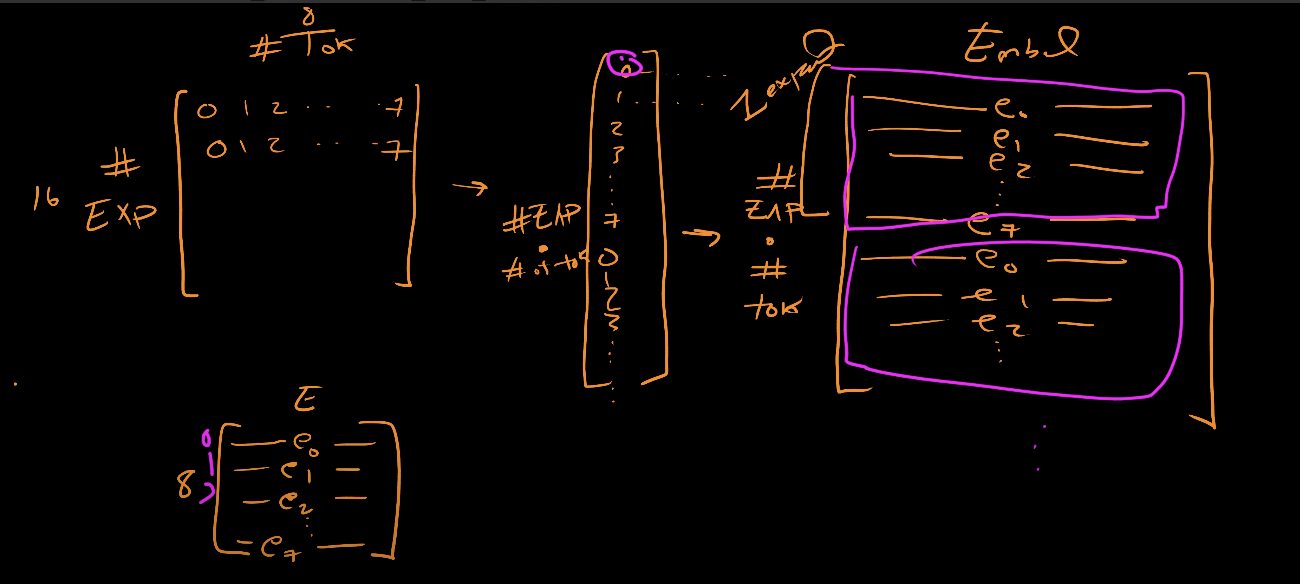

In [60]:
if __name__ == "__main__":
    
    config = Llama4TextConfig(hidden_size=768,
                              intermediate_size=786*2,  
                              intermediate_size_mlp=768*2
                              )

    rand = torch.randn(2, 2, 768, dtype=torch.float32)

    moe = Llama4TextMoe(config)

    moe(rand)

router_logits.shape: torch.Size([4, 16]) meaning [batch_size * seq_len, num_local_experts] means how many tokens each expert will get

hidden_states.shape: torch.Size([4, 768]) meaning [batch_size * seq_len, hidden_dim] means the hidden states of each token

router_top_value.shape: torch.Size([4, 2]) meaning [batch_size * seq_len, top_k] means the top k values for each expert 

router_indices.shape: torch.Size([4, 2]) meaning [batch_size * seq_len, top_k] means the indices of the top k values for each expert

matrix of -inf shape of (batch_size * seq_len, num_local_experts)

router_scores: tensor([[  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
           -inf,   -inf, 0.4410,   -inf, 0.8669,   -inf,   -inf],
        [  -inf,   -inf,   -inf,   -inf,   -inf, 1.0849,   -inf,   -inf,   -inf,
           -inf,   -inf,   -inf,   -inf, 0.4401,   -inf,   -inf],
        [  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
           -inf,   -inf,   -

In [ ]:
class Llama4TextRotaryEmbedding(nn.Module):
    
    def __init__(self, config, device=None):
        super(Llama4TextRotaryEmbedding, self).__init__()

        

In [ ]:
class Llama4TextL2Norm(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

In [ ]:
class Llama4TextRMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-5):

        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(hidden_size))


In [ ]:
class Cache:
    """
    KV Cache Method that is close to the Huggingface DynamicCache
    https://github.com/huggingface/transformers/blob/main/src/transformers/cache_utils.py
    """

    def __init__(self, config):

In [ ]:
class Llama4TextAttention(nn.Module):
    def __init__(self, config, layer_idx):
        super(Llama4TextAttention, self).__init__()

In [ ]:
class Llama4TextDecoderLayer(nn.Module):

    def __init__(self, config, layer_idx):
        super(Llama4TextDecoderLayer, self).__init__()

In [ ]:
class Llama4TextModel(nn.Module):

    def __init__(self, config):
        super(Llama4TextModel, self).__init__()

In [ ]:

class Llama4ForCausalLM(nn.Module):

    def __init__(self, config):
        super(Llama4ForCausalLM, self).__init__()

        self.model = Llama4TextModel(config)
        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)


In [ ]:

class Llama4VisionMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.activation_fn = nn.GELU()  
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size, bias=True)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size, bias=True)


In [ ]:
class Llama4VisionMLP2(nn.Module):

    """
    Pretty standard MLP Layer found in most things like the Vision Transformer

    I feel like there is a bug in Huggingface regarding the implementation of this, 
    so i am just manually passing in the in_features/out_features
    https://github.com/huggingface/transformers/issues/37321
    """
    def __init__(self, in_features, out_features, config):
        super(Llama4VisionMLP2, self).__init__()

In [ ]:
class Llama4MultiModalProjector(nn.Module):
    def __init__(self, vision_config, text_config):
        super(Llama4MultiModalProjector, self).__init__()
        self.linear_1 = nn.Linear(
            vision_config.projector_output_dim, 
            text_config.hidden_size, 
            bias=False
        )

In [ ]:
class Llama4VisionPixelShuffleMLP(nn.Module):

In [ ]:
class Llama4VisionRotaryEmbedding(nn.Module):

In [ ]:
class Llama4VisionAttention(nn.Module):

    """
    Standard ViT Attention Mechanism!
    """

In [ ]:
class Llama4VisionEncoderLayer(nn.Module):
    def __init__(self, config):
        super(Llama4VisionEncoderLayer, self).__init__()

In [ ]:
class Llama4VisionEncoder(nn.Module):

    def __init__(self, config):
        super(Llama4VisionEncoder, self).__init__()

In [ ]:
class Llama4UnfoldConvolution(nn.Module):

    def __init__(self, config):
        super(Llama4UnfoldConvolution, self).__init__()

In [ ]:
class Llama4VisionModel(nn.Module):

    def __init__(self, config):
        super(Llama4VisionModel, self).__init__()

In [10]:
class Llama4ForConditionalGeneration(nn.Module):
    pass

In [13]:
if __name__ == "__main__":
    
    config = Llama4TextConfig(hidden_size=768,
                              intermediate_size=786*2,  
                              intermediate_size_mlp=768*2
                              )

    rand = torch.randn(2, 8, 768)

    moe = Llama4TextMoe(config)

    moe(rand)

torch.Size([16, 16])
torch.Size([16, 768])
